# Gibbs Sampling for BNIRL
See Michini, Cutler, How.

Gibbs sampling to form joint posterior over subgoal partitions. Will use action primitives from action-primitives.ipynb

Action Likelihood is slightly modified to use approach outlined in notes.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pdb
from sklearn.preprocessing import normalize

In [2]:
def rational_actor(subgoal, state):
    '''Returns the action primitive tuple corresponding to rational cl controller
    
    Args:
        subgoal (list): n-length vector corresponding to subgoal location
        state (list): n-length vector for current state
    
    Returns:
        action_class (np.array): n-length array with action class
            e.g., array([1, -1, 1, -1])
    '''
    action_class = []
    
    for (sg, st) in zip(subgoal, state):
        action_class.append(np.sign(sg - st))
    
    return np.array(action_class)

In [3]:
rational_actor([1, 3, 4], [0, 0, 0])

array([1, 1, 1])

In [31]:
def bnirl_sampling(states, partition, primitives, verbose=False, debug=False, eta=1):
    '''One Gibbs sampling sweep,
    run in for loop until it converges
    
    Args:
        states [np.array]: m x n where n is actuators and m is samples
        partition [list]: m x 1 partition label for each sample
        primitives [np.array]: m x n array describing motion at sample
            e.g., primitives[0] = [1, 0, -1, 1]
                1: positive velocity or input 
                0: no velocity,
                -1: negative velocity 
        verbose [bool]: gives more info, for debugging
        eta [int]: hyperparameter for CRP
    
    Returns:
        partition [list]: updated partitions after Gibbs sweep
        '''
    dim = len(states)

    if debug:
        pdb.set_trace()
    
    # For each observation
    for i, state in enumerate(states):
        # Start by recomputing subgoal locations from partition means
        sg_means = dict()
        for j in set(partition):
            sg_mean = []
            for act in states.transpose():
                sg_mean.append(np.mean([act[k] for k in range(dim) if (partition[k] == j)]))
            sg_means[j] = np.array(sg_mean)

        if verbose:
            print('After observation %i, there are %i partitions with means %s') % (i, len(set(partition)), str(sg_means))
        
        part_posterior = []

        # For each existing partition
        for j in set(partition): # existing partitions
            crp = partition.count(j) / float(dim - 1 + eta)
#             pdb.set_trace()
            act_likelihood1 = np.e**(np.linalg.norm(primitives[i] - rational_actor(sg_means[j], state)))
#             act_likelihood = 1
            # Compute partition assignment posterior
            part_posterior.append(crp*act_likelihood1)
        # Draw new subgoal uniformly from demo states
        new_sg = states[np.random.randint(0, dim)]
        crp = eta / float(dim - 1 + eta)
        act_likelihood2 = np.e**(np.linalg.norm(primitives - rational_actor(new_sg, state)))
#         act_likelihood = 1
        part_posterior.append(crp*act_likelihood2)

        # Normalize the posterior
        part_posterior = np.array(part_posterior) / float(sum(part_posterior))
        
        if debug:
            pdb.set_trace()

        # Assign partition
        partition[i]= int(np.random.choice(list(set(partition)) + [max(set(partition)) + 1],
                                        1, p=part_posterior))        
        
#         # Consolidate partitions
#         unique_part = set(partition)
#         if len(unique_part) != (max(unique_part) + 1):

            
        
    return partition

# Test with 2D generated points

Test with 2D generated points and totally random action primitives

In [26]:
action_set = [-1, 0, 1]
primitives = []
states = []
dimm = 100

for i in range(dimm):
    primitives.append(np.random.choice(action_set, 2))

for i in range(dimm / 2):
    states.append(np.random.normal([2, 2], [1, 3]))

for i in range(len(states), dimm):
    states.append(np.random.normal([-3, -4], [2, 1]))

In [27]:
states_tr = np.array(states).transpose()

In [28]:
plt.style.use('mitch-exp')

In [29]:
primitives[0]

array([ 1, -1])

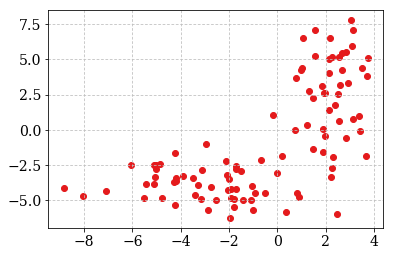

In [30]:
plt.scatter(states_tr[0], states_tr[1])

# Prep

Assign partition 0 to all points

In [67]:
partition = [0]*dimm
size = []

In [68]:
for i in range(30):
    partition = bnirl_sampling(np.array(states), partition, np.array(primitives), verbose=False, eta=0.00000001)
    size.append(len(set(partition)))

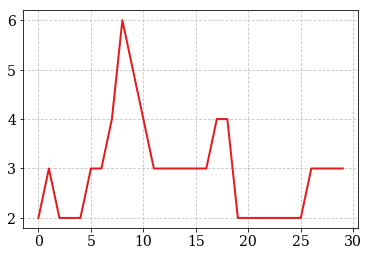

In [69]:
plt.plot(size)

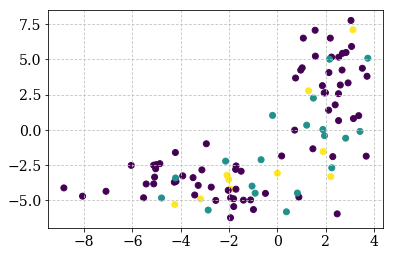

In [70]:
plt.scatter(states_tr[0], states_tr[1], c=partition)

# DP k-means

From Michael Jordan's paper.

In [272]:
def dp_kmeans(states, partition, verbose=False, debug=False, lamb=1):
    '''One Gibbs sampling sweep,
    run in for loop until it converges
    
    Args:
        states [np.array]: m x n where n is actuators and m is samples
        partition [list]: m x 1 partition label for each sample
        primitives [np.array]: m x n array describing motion at sample
            e.g., primitives[0] = [1, 0, -1, 1]
                1: positive velocity or input 
                0: no velocity,
                -1: negative velocity 
        verbose [bool]: gives more info, for debugging
        lamb [float]: cluster distance penalty, (lambda conlicts with Python)
    
    Returns:
        partition [list]: updated partitions after Gibbs sweep
        '''
    dim = len(states)

    if debug:
        pdb.set_trace()
    
    # For each observation
    for i, state in enumerate(states):
        # Start by recomputing subgoal locations from partition means
        sg_means = dict()
        for j in set(partition):
            sg_mean = []
            for act in states.transpose():
                sg_mean.append(np.mean([act[k] for k in range(dim) if (partition[k] == j)]))
            sg_means[j] = np.array(sg_mean)

        if verbose:
            print('After observation %i, there are %i partitions with means %s') % (i, len(set(partition)), str(sg_means))
        
        cluster_dist = []

        # For each existing partition
        for j in set(partition): # existing partitions
            cluster_dist.append((j, (np.linalg.norm(sg_means[j] - state))))

        min_cluster = min(cluster_dist, key=lambda t: t[1])

        # Pick closest cluster or form new cluster
        if min_cluster[1] < lamb:
            partition[i] = min_cluster[0]
        else:
            partition[i] = max(set(partition)) + 1

        if debug:
            pdb.set_trace()
        
    return partition

In [291]:
partition = [0]*dimm

In [292]:
for i in range(1):
    partition = dp_kmeans(np.array(states), partition, verbose=False, lamb=7)

# plt.scatter(states_tr[0], states_tr[1], c=partition)